In [165]:


# """
# Imports necessary packages and creates a function (fred_csv()) which scrapes data from the webpage as a csv file and adds it to a Data Frame

# | Indicator                 | FRED Series ID |
# | ------------------------- | -------------- |
# | Unemployment Rate         | `UNRATE`       |
# | Job Openings Rate         | `JTSJOR`       |
# | Quits Rate                | `JTSQUR`       |
# | Layoffs & Discharges Rate | `JTSLDR`       |
# | Initial Claims (weekly)   | `ICSA`         
# | Labor Force Participation | `CIVPART`      |
# | Part time for econreasons |`PART_TIME_ECON`|

# some private company indicators (LinkedIn)
# google trends alt data (new jobs, work near me, etc)
# avg wages 


# """
import pandas as pd
import numpy as np
import requests
import os

FRED_API_KEY = os.getenv("FRED_API_KEY")

def fred(series_id, start, end):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start,
        "observation_end": end,
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()

    obs = r.json()["observations"]

    s = pd.Series(
        [o["value"] for o in obs],
        index=pd.to_datetime([o["date"] for o in obs]),
        name=series_id
    )

    s = pd.to_numeric(s.replace(".", np.nan), errors="coerce")
    return s


def fred_bundle(series_ids, start, end, weekly_to_monthly=None):
    weekly_to_monthly = set(weekly_to_monthly or [])
    series_list = []

    for sid in series_ids:
        s = fred(sid, start, end)

        # Convert weekly to monthly if needed
        if sid in weekly_to_monthly:
            s = s.resample("ME").mean()
        else:
            s = s.resample("ME").last()

        series_list.append(s)

    df = pd.concat(series_list, axis=1).dropna()
    return df


# -----------------------------------
# Pull your labor market data
# -----------------------------------

start = "2000-01-01"
end   = "2026-12-31"   # safe to set ahead

series_ids = ["UNRATE", "JTSJOR", "JTSQUR", "JTSLDR", "ICSA", "CIVPART", "LNS12032196", "LNS13026638", "CES0500000003"]

data = fred_bundle(series_ids, start, end, weekly_to_monthly=["ICSA"])

data = data.rename(columns={
    "LNS12032196": "PART_TIME_ECON",
    "LNS13026638": "PERM_JOB_LOSER",
    "CES0500000003": "WAGE_LEVEL"
})

# Create wage growth year-over-year
data["WAGE_GROWTH_YOY"] = data["WAGE_LEVEL"].pct_change(12)

# Drop first 12 months (since YoY requires lag)
data = data.dropna()

data = data.drop(columns=["WAGE_LEVEL"])


print("Latest month with all series:", data.index.max())
data.tail()


Latest month with all series: 2025-12-31 00:00:00


,UNRATE,JTSJOR,JTSQUR,JTSLDR,ICSA,CIVPART,PART_TIME_ECON,PERM_JOB_LOSER,WAGE_GROWTH_YOY
2025-07-31,4.3,4.3,2.0,1.1,221250.0,62.2,1289.0,1894.0,0.039624
2025-08-31,4.3,4.3,1.9,1.1,230000.0,62.3,1332.0,1931.0,0.039750
2025-09-30,4.4,4.6,2.0,1.1,234750.0,62.5,1200.0,2012.0,0.038483
2025-11-30,4.5,4.2,2.0,1.1,217600.0,62.5,1650.0,1936.0,0.043429
2025-12-31,4.4,3.9,2.0,1.1,219000.0,62.4,1514.0,1969.0,0.039888


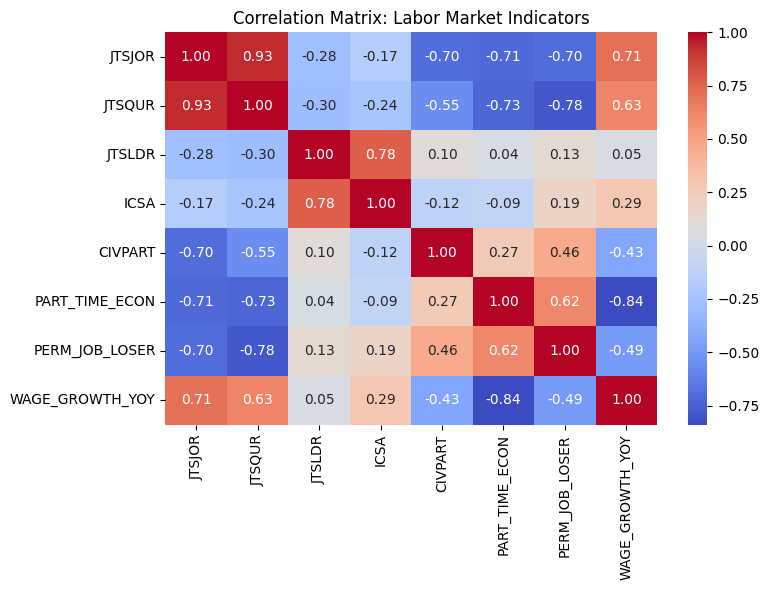

JTSJOR: -0.058
JTSQUR: 0.018
JTSLDR: 0.146
ICSA: -0.241
CIVPART: 0.251
PART_TIME_ECON: -0.035
PERM_JOB_LOSER: -0.091
WAGE_GROWTH_YOY: -0.134


In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# 3-month forward change
data["UNRATE_3M_CHANGE"] = data["UNRATE"].shift(-3) - data["UNRATE"]

data = data.dropna()

indicators = data.drop(columns=["UNRATE", "UNRATE_3M_CHANGE"])
corr_matrix = indicators.corr()
corr_matrix



plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Labor Market Indicators")
plt.tight_layout()
plt.show()

predictors = ["JTSJOR", "JTSQUR", "JTSLDR", "ICSA", "CIVPART", "PART_TIME_ECON", "PERM_JOB_LOSER", "WAGE_GROWTH_YOY"]

for var in predictors:
    corr = data[var].corr(data["UNRATE_3M_CHANGE"])
    print(f"{var}: {corr:.3f}")

pre = data.loc[:'2019-12-31']
post = data.loc['2020-01-01':]


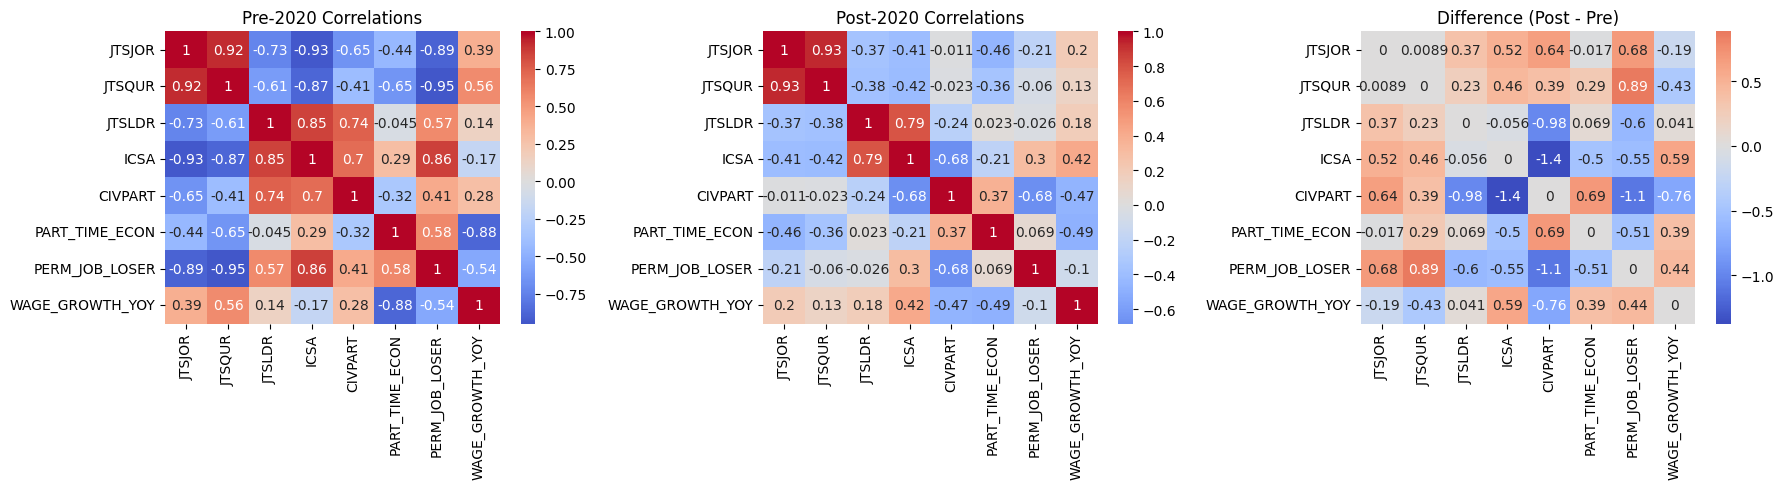

In [167]:


# Use indicators only (exclude unemployment change)
cols = predictors

pre_corr = pre[cols].corr()
post_corr = post[cols].corr()

corr_diff = post_corr - pre_corr

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.heatmap(pre_corr, annot=True, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Pre-2020 Correlations")

sns.heatmap(post_corr, annot=True, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Post-2020 Correlations")

sns.heatmap(corr_diff, annot=True, cmap="coolwarm", center=0, ax=axes[2])
axes[2].set_title("Difference (Post - Pre)")

plt.tight_layout()
plt.show()


In [168]:
data["UNRATE_3M_PCT_CHANGE"] = (
    (data["UNRATE"].shift(-3) - data["UNRATE"]) 
    / data["UNRATE"]
)
data = data.dropna()

In [169]:
#Below is running a regression with indicators pre/post 2020

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()

data_scaled = data.copy()
data_scaled[predictors] = scaler.fit_transform(data[predictors])

pre = data_scaled.loc[:'2019-12-31']
post = data_scaled.loc['2020-04-01':]


In [170]:
model_pre_HAC = sm.OLS(y_pre, X_pre).fit(cov_type="HAC", cov_kwds={"maxlags": 3})
model_post_HAC = sm.OLS(y_post, X_post).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

print(model_pre_HAC.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.656
Model:                              OLS   Adj. R-squared:                  0.636
Method:                   Least Squares   F-statistic:                     12.56
Date:                  Wed, 18 Feb 2026   Prob (F-statistic):           2.28e-13
Time:                          21:40:03   Log-Likelihood:                 272.99
No. Observations:                   144   AIC:                            -528.0
Df Residuals:                       135   BIC:                            -501.3
Df Model:                             8                                         
Covariance Type:                    HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.

In [171]:
print(model_post_HAC.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.610
Model:                              OLS   Adj. R-squared:                  0.554
Method:                   Least Squares   F-statistic:                     34.30
Date:                  Wed, 18 Feb 2026   Prob (F-statistic):           6.86e-19
Time:                          21:40:03   Log-Likelihood:                -23.430
No. Observations:                    65   AIC:                             64.86
Df Residuals:                        56   BIC:                             84.43
Df Model:                             8                                         
Covariance Type:                    HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.

In [172]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[predictors] = scaler.fit_transform(data[predictors])

pre = data_scaled.loc[:'2019-12-31'].copy()
post = data_scaled.loc['2020-01-01':].copy()

import statsmodels.api as sm

X_pre = sm.add_constant(pre[predictors])
y_pre = pre["UNRATE_3M_PCT_CHANGE"]
model_pre = sm.OLS(y_pre, X_pre).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

X_post = sm.add_constant(post[predictors])
y_post = post["UNRATE_3M_PCT_CHANGE"]
model_post = sm.OLS(y_post, X_post).fit(cov_type="HAC", cov_kwds={"maxlags": 3})


In [173]:
comparison = pd.DataFrame({
    "Pre_Coeff": model_pre.params,
    "Pre_pval": model_pre.pvalues,
    "Post_Coeff": model_post.params,
    "Post_pval": model_post.pvalues
})

comparison


,Pre_Coeff,Pre_pval,Post_Coeff,Post_pval
const,0.014444,0.355271,1.913751,0.036437
JTSJOR,-0.038465,0.152280,-0.389916,0.091432
JTSQUR,-0.024769,0.084238,0.646789,0.025529
JTSLDR,0.042813,0.072727,-0.097055,0.493304
ICSA,0.136881,0.033973,0.391314,0.151269
CIVPART,-0.006108,0.626699,1.333206,0.062641
PART_TIME_ECON,-0.039219,0.009342,0.680980,0.107898
PERM_JOB_LOSER,-0.055054,0.000005,-0.048231,0.845168
WAGE_GROWTH_YOY,-0.005900,0.792811,-0.129974,0.216368


In [174]:
print(model_pre.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.626
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     10.21
Date:                  Wed, 18 Feb 2026   Prob (F-statistic):           2.98e-11
Time:                          21:40:04   Log-Likelihood:                 287.95
No. Observations:                   154   AIC:                            -557.9
Df Residuals:                       145   BIC:                            -530.6
Df Model:                             8                                         
Covariance Type:                    HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.

In [175]:
print(model_post.summary())

                             OLS Regression Results                             
Dep. Variable:     UNRATE_3M_PCT_CHANGE   R-squared:                       0.610
Model:                              OLS   Adj. R-squared:                  0.554
Method:                   Least Squares   F-statistic:                     34.30
Date:                  Wed, 18 Feb 2026   Prob (F-statistic):           6.86e-19
Time:                          21:40:04   Log-Likelihood:                -23.430
No. Observations:                    65   AIC:                             64.86
Df Residuals:                        56   BIC:                             84.43
Df Model:                             8                                         
Covariance Type:                    HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.

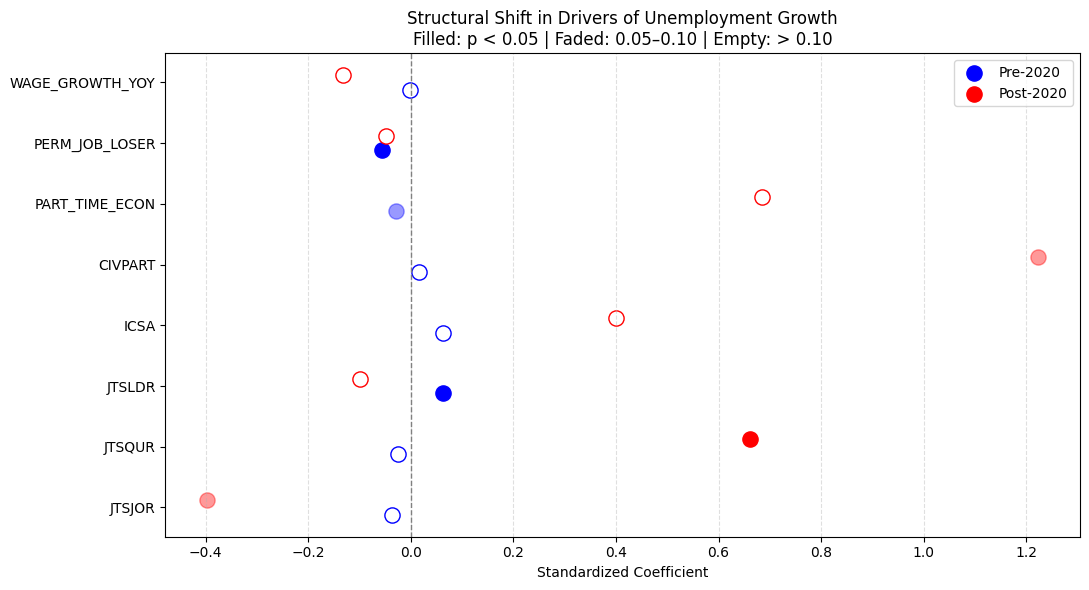

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Drop constant
plot_df = results.drop(index="const", errors="ignore")

variables = plot_df.index
y_pos = np.arange(len(variables))

pre_coeff = plot_df["Pre_Coeff"]
post_coeff = plot_df["Post_Coeff"]

pre_p = plot_df["Pre_pval"]
post_p = plot_df["Post_pval"]

plt.figure(figsize=(11,6))

def plot_points(coeffs, pvals, y_offset, color, label):
    for i, (coef, p) in enumerate(zip(coeffs, pvals)):
        
        if p < 0.05:
            marker_style = dict(marker='o', facecolor=color, edgecolor=color)
        
        elif p < 0.10:
            marker_style = dict(marker='o', facecolor=color, edgecolor=color, alpha=0.4)
        
        else:
            marker_style = dict(marker='o', facecolor='white', edgecolor=color)
        
        plt.scatter(coef, y_pos[i] + y_offset, s=120, **marker_style)

    # Dummy point for legend
    plt.scatter([], [], s=120, facecolor=color, edgecolor=color, label=label)

# Plot pre and post
plot_points(pre_coeff, pre_p, -0.12, "blue", "Pre-2020")
plot_points(post_coeff, post_p, +0.12, "red", "Post-2020")

plt.axvline(0, color="gray", linestyle="--", linewidth=1)

plt.yticks(y_pos, variables)
plt.xlabel("Standardized Coefficient")
plt.title("Structural Shift in Drivers of Unemployment Growth\n"
          "Filled: p < 0.05 | Faded: 0.05–0.10 | Empty: > 0.10")

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
